Consider to add the star ratings as one column

In [91]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 144

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set( style='white' )

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def cos_similarity(vec0, vec1):
    '''
    vec0, vec1: 1d np.array
    '''    
    print np.dot(vec0, vec1)/(np.linalg.norm(vec0)*np.linalg.norm(vec1))
    return cosine_similarity(vec0.reshape(1,-1), vec1.reshape(1,-1))

In [16]:
vec0 = np.array([1,1,1])
vec1 = np.array([1,1,-1])
norm(vec0)

1.7320508075688772

In [32]:
cos_similarity(vec0, vec1)

0.333333333333


array([[ 0.33333333]])

In [17]:
from sklearn.preprocessing import normalize
w = np.array([[1,1,-1],
             [1,1,1]])
print norm(w)
normalize(w, norm='l2', axis=1)

2.44948974278


/opt/conda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


array([[ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027,  0.57735027]])

In [36]:
t,s,d = np.linalg.svd(w)

## Read directly from data_bagofwords

In [202]:
from bag_of_words import *

In [203]:
df = get_data()

In [204]:
df.head()

,Brand,Price,Product_name,Rating,Review Votes,Reviews
0,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,4,1,good
1,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,2,1,got phone seemed good condition tried charging...
2,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,5,1,highly recommend case like product return mone...
3,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,5,0,ok
4,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,5,0,perfect


In [205]:
df_train, df_test, df_predict = split_df(df, 10000, 2000, 2000)

In [206]:
pd.isnull(df).sum()

Brand           0
Price           0
Product_name    0
Rating          0
Review Votes    0
Reviews         0
dtype: int64

In [207]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 2000)
train_features = get_train_features_bw(df_train.Reviews, vectorizer)

In [208]:
vocab = vectorizer.get_feature_names() #get vocabulary
print len(vocab)
vocab[:10]

2000


[u'1080',
 u'ability',
 u'able',
 u'absolute',
 u'absolutely',
 u'accept',
 u'acceptable',
 u'access',
 u'accessories',
 u'accidentally']

In [9]:
from numpy.linalg import norm 
import numpy as np

print train_features.shape
print train_features[0].shape
print norm(train_features)

(10000, 2000)
(2000,)
576.386155281


In [10]:
from sklearn.preprocessing import normalize

train_features_normalized = normalize(train_features, norm='l2', axis=1)

In [11]:
print norm(train_features[0])
print norm(train_features_normalized[0])

5.9160797831
1.0


For normalized vectors, the cos similarity is equal to np.dot(vec0, vec1).

In [186]:
def get_similarity_matrix(train_features_normalized):
    n = train_features_normalized.shape[0]
    sim_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if j >= i:
                sim_matrix[i, j] = np.dot(train_features_normalized[i], train_features_normalized[j])
            else:
                sim_matrix[i, j] = sim_matrix[j, i]
    return sim_matrix

In [13]:
sim_matrix = get_similarity_matrix( train_features_normalized )

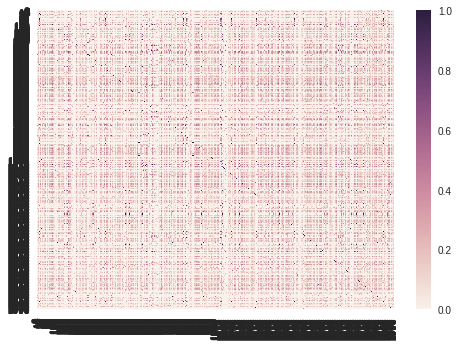

In [27]:
import seaborn as sns

sns.heatmap(sim_matrix)

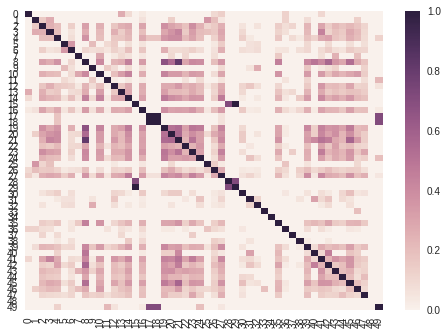

In [28]:
sns.heatmap(sim_matrix[:50,:50])

In [31]:
df_train[17:19]

,Brand,Price,Product_name,Rating,Review Votes,Reviews
362912,Samsung,0.0,Samsung Galaxy S6 SM-G920A 32GB Gold Smartphon...,5,0,excellent
23783,LG,0.0,LG G4 H811 T-Mobile GSM Unlocked 4G LTE Androi...,5,0,excellent


In [32]:
df_train[28:30]

,Brand,Price,Product_name,Rating,Review Votes,Reviews
357470,Samsung,179.99,Samsung Galaxy S4 I545 16GB Verizon CDMA 4G LT...,5,0,excelente producto
159569,Samsung,0.00,"Samsung Galaxy Rush (SPH-M830) Boost Mobile, T...",5,0,excelente


## Topic Models

In [14]:
t,s,d = np.linalg.svd(train_features_normalized, full_matrices=False)

In [15]:
d.shape

(2000, 2000)

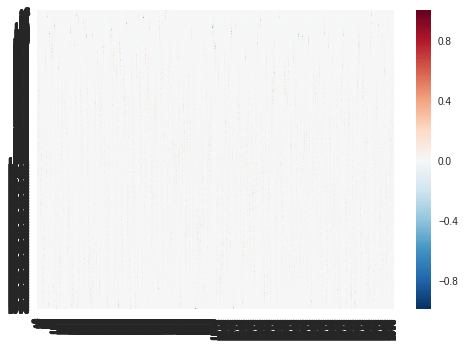

In [16]:
sns.heatmap(d)

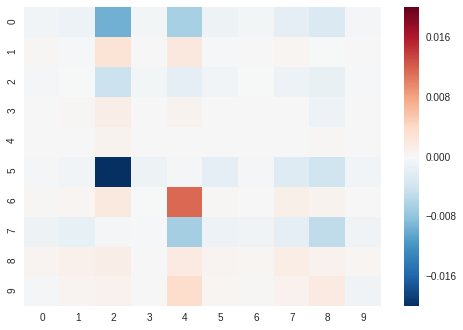

In [18]:
ax = sns.heatmap(d[:10, :10] )

In [23]:
s[:20]

array([ 34.83829233,  22.58802574,  17.96400933,  16.93198365,
        15.1084409 ,  14.50843164,  13.10756818,  11.07495153,
        10.82560442,  10.41245359,  10.27874637,  10.01750221,
         9.29874227,   8.96596552,   8.89878783,   8.71653531,
         8.49282245,   8.20203124,   7.80373744,   7.60700798])

## Find the most relavant review for the 20 most popular topics

In [92]:
train_features_normalized[0].shape

(2000,)

In [93]:
def vec_dir(vec):
    if sum(vec) > 0:
        return True #positive
    else:
        return False #negative

def find_review_in_topics(num=20):
    max_sim_list = []
    max_ind_list = []
    for j in range(num):
        topic_vec = d[j]
        if not vec_dir(topic_vec):
            topic_vec = -topic_vec
        max_sim = -float('inf')
        max_ind = 0
        for i in range(train_features_normalized.shape[0]):
            sim = np.dot(train_features_normalized[i], topic_vec)
            if sim > max_sim:
                max_sim = sim
                max_ind = i
        max_sim_list.append(max_sim)
        max_ind_list.append(max_ind)
        print 'topic %d: review %d, similarity %f' %(j, max_ind, max_sim)      
    return max_sim_list, max_ind_list

In [109]:
max_sim_list, max_ind_list = find_review_in_topics(num=30)

topic 0: review 2085, similarity 0.853959
topic 1: review 139, similarity 0.237202
topic 2: review 1980, similarity 0.296643
topic 3: review 89, similarity 0.982874
topic 4: review 2, similarity 0.997216
topic 5: review 3655, similarity 0.793205
topic 6: review 34, similarity 0.958577
topic 7: review 6756, similarity 0.482203
topic 8: review 2787, similarity 0.272689
topic 9: review 2787, similarity 0.300313
topic 10: review 859, similarity 0.756819
topic 11: review 6556, similarity 0.316308
topic 12: review 142, similarity 0.916686
topic 13: review 2866, similarity 0.563972
topic 14: review 51, similarity 0.859641
topic 15: review 5005, similarity 0.517905
topic 16: review 1253, similarity 0.445316
topic 17: review 850, similarity 0.470820
topic 18: review 9396, similarity 0.380932
topic 19: review 8937, similarity 0.471958
topic 20: review 9155, similarity 0.227450
topic 21: review 8595, similarity 0.350080
topic 22: review 8928, similarity 0.414087
topic 23: review 3425, similarity 

In [201]:
from heapq import heappush, heappop

topic_words = {}
for j in range(30):
    topic_words[j] = []
    for i in range(len(d[j])):        
        if abs(d[j,i])>0.2:
            heappush(topic_words[j], (-abs(d[j,i]), vocab[i]))

In [118]:
from heapq import heappush, heappop

topic_words = {}
for j in range(30):
    topic_words[j] = []
    for i in range(len(d[j])):        
        if abs(d[j,i])>0.2:
            heappush(topic_words[j], (d[j,i], i))

In [55]:
df_train[88:89]

,Brand,Price,Product_name,Rating,Review Votes,Reviews
486906,Samsung,149.99,"Samsung Galaxy S8+ (64GB) G955FD 6.2"" Dual SIM...",5,0,perfectol


In [61]:
vocab[1255]

u'phone'

In [70]:
df_train[88:89]

,Brand,Price,Product_name,Rating,Review Votes,Reviews
486906,Samsung,149.99,"Samsung Galaxy S8+ (64GB) G955FD 6.2"" Dual SIM...",5,0,perfectol


In [106]:
for i in max_ind_list:
    print df_train.Reviews[i:i+1]

584544    discontinued phone
Name: Reviews, dtype: object
131514    great phone
Name: Reviews, dtype: object
113667    phone not wirk
Name: Reviews, dtype: object
140663    excellent
Name: Reviews, dtype: object
216917    excelente
Name: Reviews, dtype: object
628640    g not goog
Name: Reviews, dtype: object
642554    love
Name: Reviews, dtype: object
22967    product works fine
Name: Reviews, dtype: object
558785    works
Name: Reviews, dtype: object
558785    works
Name: Reviews, dtype: object
303968    excellentgreat sellergreat product thx
Name: Reviews, dtype: object
271518    bought phone sister liked much wanted one asto...
Name: Reviews, dtype: object
382983    perfect
Name: Reviews, dtype: object
350294    no era ascend p l
Name: Reviews, dtype: object
443408    ok
Name: Reviews, dtype: object
523904    awesome price
Name: Reviews, dtype: object
403260    really good phone battery battery life joke ch...
Name: Reviews, dtype: object
341626    different one friend know one cop

In [89]:
a = df_train.Reviews[ df_train.index[max_ind_list[-2]] ]

In [90]:
print a

new pfhone battery weak hour battery dead disapointed company send new battery problem


In [87]:
df.loc[:, 'Reviews_bw'] = ''

In [88]:
df.head()

,Brand,Price,Product_name,Rating,Review Votes,Reviews,Reviews_bw
0,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,4,1,good,
1,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,2,1,got phone seemed good condition tried charging...,
2,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,5,1,highly recommend case like product return mone...,
3,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,5,0,ok,
4,Apple,168.99,Apple iPhone 6 64GB Space Gray - (Verizon Wire...,5,0,perfect,


## Visualization

In [148]:
word_index = {}
word_index_2 = {}
iteri = 0
for key in topic_words:
    for item in topic_words[key]:
        if item[1] not in word_index:
            word_index[item[1]] = iteri
            word_index_2[iteri] = item[1]
            iteri += 1
        else:
            continue

In [150]:
print word_index[1255]
print word_index_2[0]

0
1255


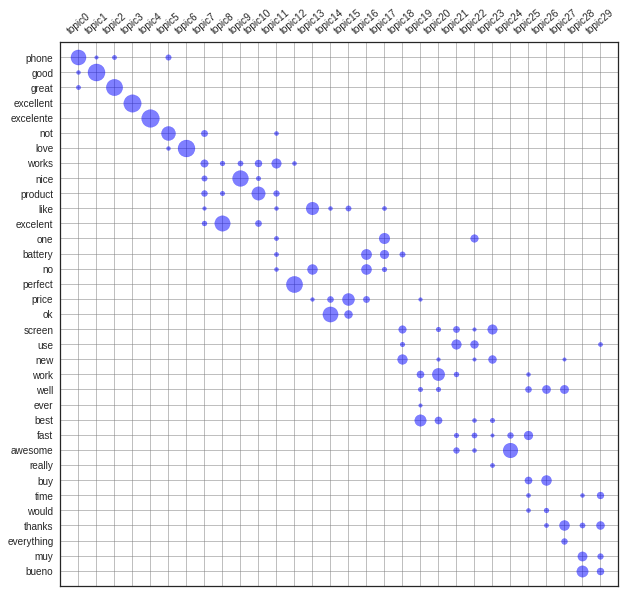

In [156]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.grid(color='grey', linestyle='-', linewidth=0.5)

for x in topic_words:
    for item in topic_words[x]:
        ax.scatter(x, word_index[item[1]], s=np.pi*abs(item[0])**2*100, c='blue', alpha=0.5)

ax.xaxis.tick_top()
ax.set_xlim(-1, 30)
ax.set_xticks(range(30))
ax.set_xticklabels(['topic%d' %i for i in range(30)], rotation=40, ha='center')


ax.set_ylim(-1,35)
ax.set_yticks(range(35))
ax.set_yticklabels([ vocab[word_index_2[i]] for i in range(35)])
ax.invert_yaxis()
fig.savefig('cluster_0.pdf')

## Filter only nouns

In [159]:
import nltk

text = nltk.word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]

In [215]:
text = nltk.word_tokenize(df.Reviews[2])
nltk.pos_tag(text)

[(u'highly', 'RB'),
 (u'recommend', 'JJ'),
 (u'case', 'NN'),
 (u'like', 'IN'),
 (u'product', 'NN'),
 (u'return', 'VB'),
 (u'money', 'NN'),
 (u'fast', 'IN'),
 (u'easy', 'JJ'),
 (u'happy', 'JJ')]

In [217]:
nltk.pos_tag(vocab)

[(u'1080', 'CD'),
 (u'ability', 'NN'),
 (u'able', 'JJ'),
 (u'absolute', 'NN'),
 (u'absolutely', 'RB'),
 (u'accept', 'IN'),
 (u'acceptable', 'JJ'),
 (u'access', 'NN'),
 (u'accessories', 'NNS'),
 (u'accidentally', 'RB'),
 (u'according', 'VBG'),
 (u'account', 'NN'),
 (u'accounts', 'NNS'),
 (u'accurate', 'VBP'),
 (u'across', 'IN'),
 (u'activate', 'NN'),
 (u'activated', 'VBN'),
 (u'activation', 'NN'),
 (u'active', 'JJ'),
 (u'actual', 'JJ'),
 (u'actually', 'RB'),
 (u'ad', 'NN'),
 (u'adapter', 'NN'),
 (u'adaptor', 'NN'),
 (u'add', 'NN'),
 (u'added', 'VBD'),
 (u'adding', 'VBG'),
 (u'addition', 'NN'),
 (u'additional', 'JJ'),
 (u'adds', 'VBZ'),
 (u'adequate', 'JJ'),
 (u'adjust', 'NN'),
 (u'ads', 'NNS'),
 (u'advanced', 'VBD'),
 (u'advantage', 'NN'),
 (u'advertised', 'VBD'),
 (u'advertising', 'NN'),
 (u'advise', 'NN'),
 (u'afford', 'NN'),
 (u'affordable', 'JJ'),
 (u'afraid', 'NN'),
 (u'africa', 'NN'),
 (u'ago', 'RB'),
 (u'agree', 'JJ'),
 (u'ahead', 'RB'),
 (u'air', 'NN'),
 (u'al', 'JJ'),
 (u'alarm

In [175]:
def filter_word(vocab):
    exclude_tag = set(['RB', 'EX', 'IN', 'DT', 'CC', 'MD', 'RP', 'JJ'])
    tags = nltk.pos_tag(vocab)
    select_indices = []
    for i in range(len(vocab)):
        if tags[i][1] not in exclude_tag:
            select_indices.append(i)
    return select_indices

In [176]:
filter_tag_indices = filter_word(vocab)
len(filter_tag_indices)

1395

In [181]:
vectorizer2 = CountVectorizer(analyzer = "word",   \
                              tokenizer = None,    \
                              preprocessor = None, \
                              stop_words = None,   \
                              vocabulary= [vocab[i] for i in filter_tag_indices] )
train_features2 = vectorizer2.transform(df_train.Reviews)

In [185]:
print train_features2.shape
print train_features2_normalized.shape

(10000, 1395)
(10000, 1395)


In [183]:
train_features2_normalized = normalize(train_features2, norm='l2', axis=1)

In [191]:
t2,s2,d2 = np.linalg.svd(train_features2_normalized.toarray(), full_matrices=False)

In [192]:
max_sim_list, max_ind_list = find_review_in_topics(num=30)

topic 0: review 2085, similarity 0.853959
topic 1: review 139, similarity 0.237202
topic 2: review 1980, similarity 0.296643
topic 3: review 89, similarity 0.982874
topic 4: review 2, similarity 0.997216
topic 5: review 3655, similarity 0.793205
topic 6: review 34, similarity 0.958577
topic 7: review 6756, similarity 0.482203
topic 8: review 2787, similarity 0.272689
topic 9: review 2787, similarity 0.300313
topic 10: review 859, similarity 0.756819
topic 11: review 6556, similarity 0.316308
topic 12: review 142, similarity 0.916686
topic 13: review 2866, similarity 0.563972
topic 14: review 51, similarity 0.859641
topic 15: review 5005, similarity 0.517905
topic 16: review 1253, similarity 0.445316
topic 17: review 850, similarity 0.470820
topic 18: review 9396, similarity 0.380932
topic 19: review 8937, similarity 0.471958
topic 20: review 9155, similarity 0.227450
topic 21: review 8595, similarity 0.350080
topic 22: review 8928, similarity 0.414087
topic 23: review 3425, similarity 

In [194]:
from heapq import heappush, heappop

topic_words2 = {}
for j in range(30):
    topic_words2[j] = []
    for i in range(len(d[j])):        
        if abs(d[j,i])>0.2:
            heappush(topic_words2[j], (d[j,i], i))

In [195]:
word_index = {}
word_index_2 = {}
iteri = 0
for key in topic_words2:
    for item in topic_words2[key]:
        if item[1] not in word_index:
            word_index[item[1]] = iteri
            word_index_2[iteri] = item[1]
            iteri += 1
        else:
            continue

IndexError: list index out of range

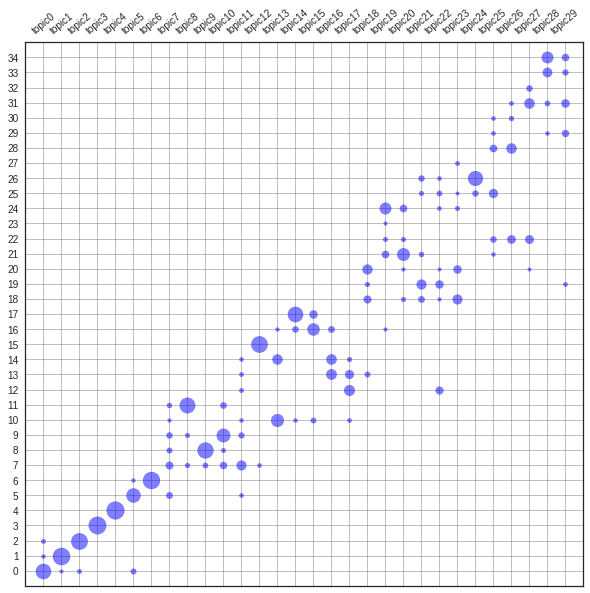

In [199]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.grid(color='grey', linestyle='-', linewidth=0.5)

for x in topic_words:
    for item in topic_words2[x]:
        ax.scatter(x, word_index[item[1]], s=np.pi*abs(item[0])**2*100, c='blue', alpha=0.5)

ax.xaxis.tick_top()
ax.set_xlim(-1, 30)
ax.set_xticks(range(30))
ax.set_xticklabels(['topic%d' %i for i in range(30)], rotation=40, ha='center')


ax.set_ylim(-1,35)
ax.set_yticks(range(35))
ax.set_yticklabels([ vocab[filter_tag_indices[word_index_2[i]]] for i in range(10)])
ax.invert_yaxis()